<a href="https://colab.research.google.com/github/rithwik25/fake_image_detection/blob/main/fid_ela_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# sns.set(style='white', context='notebook', palette='deep')

from tqdm import tqdm
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.JPG') or f.endswith('.png') or f.endswith('.tif')]

def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    im = Image.open(filename)
    bm = im.convert('RGB')
    im.close()
    im=bm
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    im.close()
    bm.close()
    resaved_im.close()
    del filename
    del resaved_filename
    del im
    del bm
    del resaved_im
    del extrema
    del max_diff
    del scale
    return ela_im


In [4]:
from tqdm import tqdm
import os

path_original = '/content/drive/MyDrive/cs2/CASIA2/Au/'
path_tampered = '/content/drive/MyDrive/cs2/CASIA2/Tp/'

images = []

# Check images in the original path without file size filter
for file in tqdm(os.listdir(path_original)):
    try:
        if file.endswith(('jpg', 'JPG', 'jpeg', 'JPEG')):
            full_path = os.path.join(path_original, file)  # Correctly join paths
            line = full_path + ',0\n'
            images.append(line)
    except Exception as e:
        print("Error with file:", full_path, "| Error:", e)

# Check images in the tampered path without file size filter
for file in tqdm(os.listdir(path_tampered)):
    try:
        if file.endswith(('jpg', 'tif')):
            full_path = os.path.join(path_tampered, file)  # Correctly join paths
            line = full_path + ',1\n'
            images.append(line)
    except Exception as e:
        print("Error with file:", full_path, "| Error:", e)

# Debugging: Check if images list is populated
print("Number of images:", len(images))
print("Sample images:", images[:5])


100%|██████████| 5139/5139 [00:00<00:00, 309291.55it/s]

Number of images: 12574
Sample images: ['/content/drive/MyDrive/cs2/CASIA2/Au/Au_sec_00090.jpg,0\n', '/content/drive/MyDrive/cs2/CASIA2/Au/Au_sec_00095.jpg,0\n', '/content/drive/MyDrive/cs2/CASIA2/Au/Au_sec_00067.jpg,0\n', '/content/drive/MyDrive/cs2/CASIA2/Au/Au_sec_00082.jpg,0\n', '/content/drive/MyDrive/cs2/CASIA2/Au/Au_sec_00080.jpg,0\n']


In [5]:
import pandas as pd

# Create the DataFrame from images list
image_name = [img.split(',')[0] for img in images]
label = [img.split(',')[1].strip() for img in images]

# Construct the DataFrame
dataset = pd.DataFrame({'image': image_name, 'class_label': label})

sample_size = 5600  # Choose a smaller sample size
reduced_dataset = dataset.sample(n=sample_size, random_state=1)  # Randomly sample
reduced_dataset.to_csv('reduced_dataset_CASIA2.csv', index=False)
# Save to CSV
# dataset.to_csv('dataset_CASIA2.csv', index=False)

In [6]:
dataset = pd.read_csv('reduced_dataset_CASIA2.csv')
dataset

,image,class_label
0,/content/drive/MyDrive/cs2/CASIA2/Au/Au_pla_30...,0
1,/content/drive/MyDrive/cs2/CASIA2/Au/Au_art_30...,0
2,/content/drive/MyDrive/cs2/CASIA2/Tp/Tp_S_NNN_...,1
3,/content/drive/MyDrive/cs2/CASIA2/Au/Au_txt_00...,0
4,/content/drive/MyDrive/cs2/CASIA2/Au/Au_nat_30...,0
...,...,...
5595,/content/drive/MyDrive/cs2/CASIA2/Au/Au_ani_30...,0
5596,/content/drive/MyDrive/cs2/CASIA2/Au/Au_pla_30...,0
5597,/content/drive/MyDrive/cs2/CASIA2/Au/Au_pla_20...,0
5598,/content/drive/MyDrive/cs2/CASIA2/Au/Au_ind_30...,0


In [7]:
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
from tqdm import tqdm

# Initialize X and Y lists
X = []
Y = []

# Process each image in the dataset
for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    try:
        # Convert to ELA image and resize
        ela_image = convert_to_ela_image(row[0], 80)
        resized_image = ela_image.resize((128, 128), resample=Image.LANCZOS)

        # Flatten the image array and normalize
        X.append(np.array(resized_image).flatten() / 255.0)
        Y.append(row[1])
    except Exception as e:
        print(f"Error processing image {row[0]}: {e}")

# Clean up
del dataset


  0%|          | 0/5600 [00:00<?, ?it/s]<ipython-input-7-b960902968b5>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ela_image = convert_to_ela_image(row[0], 80)
<ipython-input-7-b960902968b5>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y.append(row[1])
100%|██████████| 5600/5600 [39:41<00:00,  2.35it/s]


In [8]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Assuming X and Y are already defined
XX = np.array(X)  # Convert list of images to a NumPy array
YY = to_categorical(Y, 2)  # One-hot encode labels

# Clean up memory
del X
del Y

# Reshape XX for the neural network
XX = XX.reshape(-1, 128, 128, 3)  # Reshape for CNN input

# Print shapes for verification
print("XX shape:", XX.shape)
print("YY shape:", YY.shape)

XX shape: (5600, 128, 128, 3)
YY shape: (5600, 2)


In [9]:
np.save("pixel_value_array_128.npy", XX)  # Save pixel values as a .npy file
np.save("label_128.npy", YY)  # Save labels as a .npy file

# To load the saved arrays anytime in future you can use the below code:

# XX_loaded = np.load("pixel_value_array_128.npy")  # Load pixel values
# YY_loaded = np.load("label_128.npy")  # Load labels

# Check the shapes to ensure they are loaded correctly
# print("Loaded XX shape:", XX_loaded.shape)
# print("Loaded YY shape:", YY_loaded.shape)


Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

# Assuming X and Y are already defined as your features and labels
# X contains pixel values and Y contains labels

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(XX, YY, test_size=0.2, random_state=5)

# Check the shapes of the resulting datasets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", Y_train.shape)
print("Validation labels shape:", Y_val.shape)

Training data shape: (4480, 128, 128, 3)
Validation data shape: (1120, 128, 128, 3)
Training labels shape: (4480, 2)
Validation labels shape: (1120, 2)


CNN Building

In [11]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid',
                 activation='relu', input_shape=(128, 128, 3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

# Second convolutional layer
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid',
                 activation='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

# Max pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

# Dropout layer
model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

# Flattening the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation="softmax"))

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
optimizer = RMSprop(learning_rate=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto'
)

# Training parameters
epochs = 20
batch_size = 50

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/20
90/90 - 520s - 6s/step - accuracy: 0.6810 - loss: 0.6598 - val_accuracy: 0.7107 - val_loss: 0.5554
Epoch 2/20
90/90 - 556s - 6s/step - accuracy: 0.7571 - loss: 0.5286 - val_accuracy: 0.6804 - val_loss: 0.7076
Epoch 3/20
90/90 - 509s - 6s/step - accuracy: 0.7721 - loss: 0.4922 - val_accuracy: 0.7812 - val_loss: 0.5016
Epoch 4/20
90/90 - 516s - 6s/step - accuracy: 0.7875 - loss: 0.4677 - val_accuracy: 0.7670 - val_loss: 0.5128
Epoch 5/20
90/90 - 512s - 6s/step - accuracy: 0.8056 - loss: 0.4260 - val_accuracy: 0.8116 - val_loss: 0.4786
Epoch 6/20
90/90 - 562s - 6s/step - accuracy: 0.8315 - loss: 0.3846 - val_accuracy: 0.7616 - val_loss: 0.4975
Epoch 7/20
90/90 - 564s - 6s/step - accuracy: 0.8533 - loss: 0.3474 - val_accuracy: 0.8018 - val_loss: 0.4454
Epoch 7: early stopping


### Performance Measure
Accuracy and loss curves during training-validation

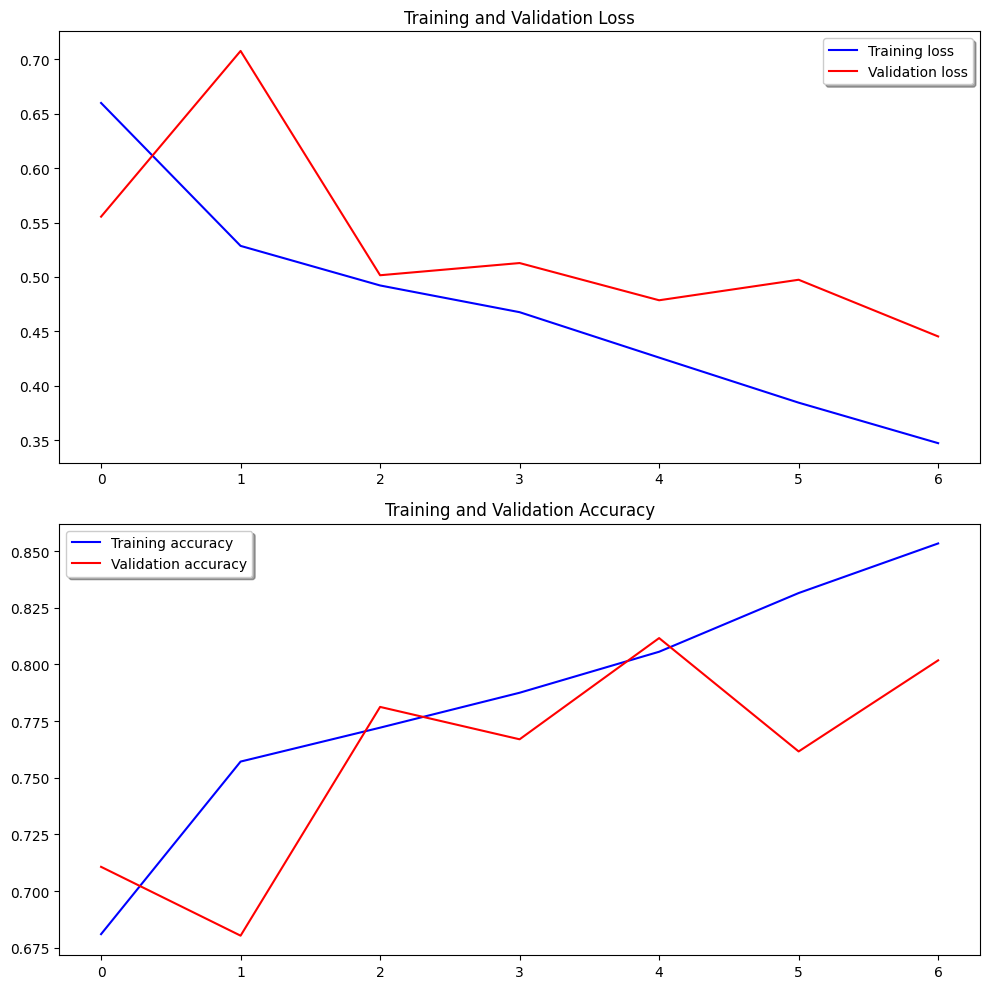

In [13]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].set_title('Training and Validation Loss')
ax[0].legend(loc='best', shadow=True)

# Plotting the training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend(loc='best', shadow=True)

# Show the plot
plt.tight_layout()
plt.show()


### Confusion Matrix

35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 848ms/step


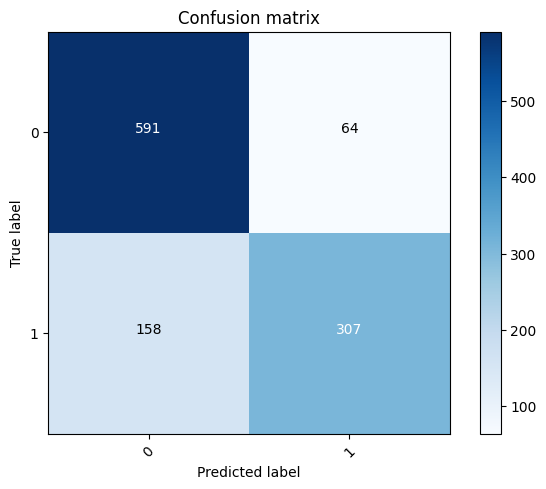

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [20]:
# Assuming X_test is preprocessed the same way as X_train
predictions = model.predict(X_val)

# If your model is for classification and outputs probabilities, you may want to get class labels:
predicted_classes = np.argmax(predictions, axis=1)  # For multi-class classification

# For binary classification (0 or 1), you might round the predictions:
# predicted_classes = (predictions > 0.5).astype("int32")

# If you want to check the accuracy of the predictions on X_test, and you have Y_test:
from sklearn.metrics import accuracy_score
# Convert Y_val from one-hot encoding to single-label format
Y_val_classes = np.argmax(Y_val, axis=1)

# Now calculate accuracy
accuracy = accuracy_score(Y_val_classes, predicted_classes)
print("Test Accuracy:", accuracy)


35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 915ms/step
Test Accuracy: 0.8017857142857143
